In [1]:
import numpy as np
import pandas as pd
from main import tree_grow, tree_grow_b, tree_pred, tree_pred_b
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from IPython.display import display, Markdown, Latex
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table
from time import time
import random

In [2]:
random.seed(3)

In [3]:
train = pd.read_csv("eclipse-metrics-packages-2.0.csv", delimiter=";")
test = pd.read_csv("eclipse-metrics-packages-3.0.csv", delimiter=";")
list(train.columns[4:44])
feats = ['pre',
 'ACD_avg',
 'ACD_max',
 'ACD_sum',
 'FOUT_avg',
 'FOUT_max',
 'FOUT_sum',
 'MLOC_avg',
 'MLOC_max',
 'MLOC_sum',
 'NBD_avg',
 'NBD_max',
 'NBD_sum',
 'NOCU',
 'NOF_avg',
 'NOF_max',
 'NOF_sum',
 'NOI_avg',
 'NOI_max',
 'NOI_sum',
 'NOM_avg',
 'NOM_max',
 'NOM_sum',
 'NOT_avg',
 'NOT_max',
 'NOT_sum',
 'NSF_avg',
 'NSF_max',
 'NSF_sum',
 'NSM_avg',
 'NSM_max',
 'NSM_sum',
 'PAR_avg',
 'PAR_max',
 'PAR_sum',
 'TLOC_avg',
 'TLOC_max',
 'TLOC_sum',
 'VG_avg',
 'VG_max',
 'VG_sum']
train_x = train[feats]
train_y = train["post"]
test_x = test[feats]
test_y = test["post"]

In [4]:
train_x_np = train_x.to_numpy()
test_x_np = test_x.to_numpy()

In [5]:
train_y_np = train_y.to_numpy()
train_y_np = np.where(train_y_np > 0, 1, 0)
test_y_np = test_y.to_numpy()
test_y_np = np.where(test_y_np > 0, 1, 0)

In [33]:
len(train_x_np)

377

In [6]:
len(test_y_np)

661

In [7]:
# Majority label prediction
majority_label = round(sum(train_y_np)/len(train_y_np))
majority_label_accuracy = sum(test_y_np)/len(test_y_np)
majority_label_accuracy

np.float64(0.4735249621785174)

In [8]:
preds_model = {}

In [9]:
start = time()
single_tree = tree_grow(train_x_np, train_y_np, 15, 5, 41)
end = time()
print(f"Training single tree took {end-start} seconds")
test_y_np_pred_st = tree_pred(test_x_np, single_tree)
preds_model["single tree"] = test_y_np_pred_st

Training single tree took 1.0486681461334229 seconds


In [10]:
# len(single_tree.y) == (len(single_tree.l.y) + len(single_tree.r.y))

In [11]:
def report_scores(y_true,y_pred):
    conf_mat = confusion_matrix(y_true,y_pred)
    tn = conf_mat[0][0]
    fp = conf_mat[0][1]
    fn = conf_mat[1][0]
    tp = conf_mat[1][1]
    print("Confusion matrix:")
    display(Markdown(f'''| True/Pred |Pos|Neg|
|-----------|---|---|
|       Pos |{tp}|{fn}|
|       Neg |{fp}|{tn}|
    '''))
    print("---------------------------------")
    print("LaTex formatting:", '''
\\begin{table}[]
\\begin{tabular}{|r|l|l|}
\\hline
True/Pred & Pos & Neg \\\ \hline''')
    print(f"Pos                             &  {tp}   &  {fn}   \\\ \hline")
    print(f"Neg                             & {fp}    &  {tn}   \\\ \hline")
    print('''\end{tabular}
\end{table}''')
    print("------------------------------------")
    print("accuracy:", accuracy_score(y_true,y_pred))
    print("precision:", precision_score(y_true,y_pred))
    print("recall:", recall_score(y_true,y_pred))

In [12]:
report_scores(test_y_np, test_y_np_pred_st)

Confusion matrix:


| True/Pred |Pos|Neg|
|-----------|---|---|
|       Pos |184|129|
|       Neg |79|269|
    

---------------------------------
LaTex formatting: 
\begin{table}[]
\begin{tabular}{|r|l|l|}
\hline
True/Pred & Pos & Neg \\ \hline
Pos                             &  184   &  129   \\ \hline
Neg                             & 79    &  269   \\ \hline
\end{tabular}
\end{table}
------------------------------------
accuracy: 0.6853252647503782
precision: 0.6996197718631179
recall: 0.5878594249201278


In [13]:
# Print the first two-layers of the tree
# Root node information
root = single_tree
split_feature = feats[root.f]
split_value = root.s
y_values = root.y
y_values_1_ratio = sum(y_values)/len(y_values)
print(f"Root values: split_feature = {split_feature}, split_value = {split_value}, y_values_1_ratio = {y_values_1_ratio}")

Root values: split_feature = pre, split_value = 4.5, y_values_1_ratio = 0.5039787798408488


In [14]:
print(np.bincount(single_tree.y))
# print(single_tree.f)
print(single_tree.s)
print(feats[single_tree.f])

[187 190]
4.5
pre


In [15]:
print(np.bincount(single_tree.l.y))
print(single_tree.l.s)
print(feats[single_tree.l.f])

[156  58]
26.5
VG_max


In [16]:
print(np.bincount(single_tree.r.y))
print(single_tree.r.s)
print(feats[single_tree.r.f])

[ 31 132]
0.1583333333333333
NOI_avg


In [17]:
start = time()
bagging_tree = tree_grow_b(train_x_np, train_y_np, 15, 5, 41, 100)
end = time()
print(f"Training bagging tree took {end-start} seconds")
test_y_np_pred_bt = tree_pred_b(test_x_np, bagging_tree)
preds_model["bagging tree"] = test_y_np_pred_bt

Training bagging tree took 76.78345370292664 seconds


In [18]:
report_scores(test_y_np, test_y_np_pred_bt)

Confusion matrix:


| True/Pred |Pos|Neg|
|-----------|---|---|
|       Pos |205|108|
|       Neg |39|309|
    

---------------------------------
LaTex formatting: 
\begin{table}[]
\begin{tabular}{|r|l|l|}
\hline
True/Pred & Pos & Neg \\ \hline
Pos                             &  205   &  108   \\ \hline
Neg                             & 39    &  309   \\ \hline
\end{tabular}
\end{table}
------------------------------------
accuracy: 0.7776096822995462
precision: 0.8401639344262295
recall: 0.6549520766773163


In [19]:
start = time()
random_tree = tree_grow_b(train_x_np, train_y_np, 15, 5, 6, 100)
end = time()
print(f"Training random forest took {end-start} seconds")
test_y_np_pred_rt = tree_pred_b(test_x_np, random_tree)
preds_model["random forest"] = test_y_np_pred_rt

Training random forest took 12.730796813964844 seconds


In [20]:
report_scores(test_y_np, test_y_np_pred_rt)

Confusion matrix:


| True/Pred |Pos|Neg|
|-----------|---|---|
|       Pos |216|97|
|       Neg |61|287|
    

---------------------------------
LaTex formatting: 
\begin{table}[]
\begin{tabular}{|r|l|l|}
\hline
True/Pred & Pos & Neg \\ \hline
Pos                             &  216   &  97   \\ \hline
Neg                             & 61    &  287   \\ \hline
\end{tabular}
\end{table}
------------------------------------
accuracy: 0.7609682299546142
precision: 0.779783393501805
recall: 0.6900958466453674


In [21]:
models = list(preds_model.keys())
for model1 in models:
    for model2 in models:
        if not(model1 == model2):
            print(f"McNemar's test {model1} vs {model2}")
            # The code in the following three lines was adopted from [1].
            table = mcnemar_table(y_target=test_y_np, y_model1=preds_model[model1], y_model2=preds_model[model2])
            chi2_, p = mcnemar(ary=table, corrected=True)
            print(f"chi² statistic: {chi2_}, p-value: {p}\n")
    models.remove(model1)

McNemar's test single tree vs bagging tree
chi² statistic: 29.75206611570248, p-value: 4.909827507614258e-08

McNemar's test single tree vs random forest
chi² statistic: 21.4375, p-value: 3.655513267962821e-06

McNemar's test random forest vs bagging tree
chi² statistic: 1.5873015873015872, p-value: 0.20771208572755318



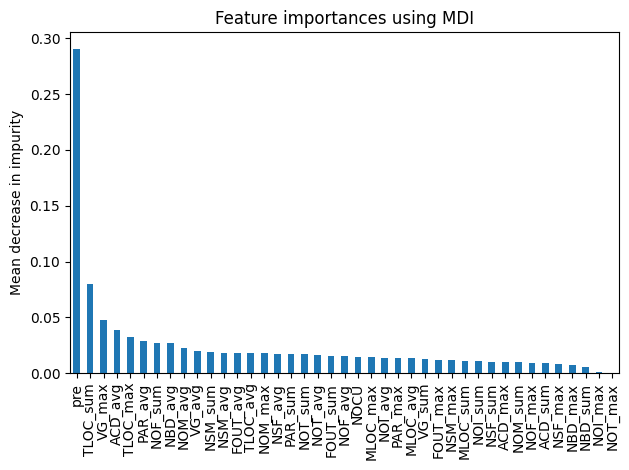

In [26]:
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
import pandas as pd
rf = BaggingClassifier(n_estimators=100)
rf.fit(train_x_np, train_y_np)
feature_importances = np.mean([
    tree.feature_importances_ for tree in rf.estimators_
], axis=0)
feature_importances

new_feature_importances, new_feats = zip(*sorted(zip(feature_importances, feats),reverse=True))

forest_importances = pd.Series(new_feature_importances, index=new_feats)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig("feature_importance.pdf", format="pdf")

In [32]:
help(rf.estimators_[0])

Help on DecisionTreeClassifier in module sklearn.tree._classes object:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy", "log_loss"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "log_loss" and "entropy" both for the
 |      Shannon information gain, see :ref:`tree_mathematical_formulation`.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      stra

# References
[1] T. Toledo Jr, “Statistical tests for comparing classification algorithms,” Medium, Jan. 04, 2022. [Online]. Available: https://towardsdatascience.com/statistical-tests-for-comparing-classification-algorithms-ac1804e79bb7